<a href="https://colab.research.google.com/github/santolina/pytorch_handbook/blob/master/PytorchHandbook_chap4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4.1 Image classfication using CIFAR-10

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import dataset

train_dataset = torchvision.datasets.CIFAR10(root='./data/', 
                                             train=True,
                                             transform = transforms.ToTensor(),
                                             download=True
                                             )

test_dataset = torchvision.datasets.CIFAR10(root='./data/', 
                                            train=False,
                                            transform = transforms.ToTensor(),
                                            download = True
                                            )
                                
image, label = train_dataset[0]
print(image.size())
print(label)

0it [00:00, ?it/s]

170500096it [00:04, 40990173.12it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified
torch.Size([3, 32, 32])
6


In [0]:
# define Dataloader

train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = 64,
    shuffle = True, 
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset, 
    batch_size = 64,
    shuffle = False, 
    num_workers = 2
)

In [4]:
# check tensor's shape

for images, labels in train_loader:
  print(images.size())
  print(images.dtype)
  print(images[0].size())
  print(labels.size())
  # insert training code
  
  break

torch.Size([64, 3, 32, 32])
torch.float32
torch.Size([3, 32, 32])
torch.Size([64])


In [10]:
class AlexNet(nn.Module):
  def __init__(self, num_classes=10):
    super(AlexNet, self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=5),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(64, 192, kernel_size=5, padding=2),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(192, 384, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(384, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(256, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2)                                   
    )
    self.classifier = nn.Linear(256, num_classes)

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x
  
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = AlexNet().to(device) #<--- 

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Linear(in_features=256, out_features=10, bias=True)
)

In [11]:
print(device)

cuda


In [0]:
# training
def train(net, criterion, optimizer, train_loader, test_loader, device, num_epoch=50):

  train_loss_list = []
  train_acc_list = []
  val_loss_list = []
  val_acc_list = []

  for epoch in range(num_epoch):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    # train=====
    # change training mode
    net.train()

    for i, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)
      
      # reset  gradient
      optimizer.zero_grad()

      # forward propagation
      outputs = net(images)

      # calc loss
      loss = criterion(outputs, labels)

      train_loss += loss.item()

      train_acc += (outputs.max(1)[1] == labels).sum().item()

      # back propagation
      loss.backward()

      # update weight
      optimizer.step()

    # average loss and accuracy
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    # val====
    # change evaluation mode
    net.eval()

    with torch.no_grad():
      for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        val_acc += (outputs.max(1)[1]==labels).sum().item()
    
      avg_val_loss = val_loss / len(test_loader.dataset)
      avg_val_acc = val_acc / len(test_loader.dataset)

    # output loss and acc of training and test

    print('Epoc [{}/{}], loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}'.format(
      epoch+1, num_epoch, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))

    # store data to plot graph
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

  return train_loss_list, train_acc_list, val_loss_list, val_acc_list, net,

In [13]:
train_loss_list, train_acc_list, val_loss_list, val_acc_list, net = train(net, criterion, optimizer, train_loader, test_loader, device, num_epoch=50)

Epoc [1/50], loss: 0.0347, val_loss: 0.0310, val_acc: 0.2556
Epoc [2/50], loss: 0.0279, val_loss: 0.0243, val_acc: 0.4171
Epoc [3/50], loss: 0.0236, val_loss: 0.0226, val_acc: 0.4813
Epoc [4/50], loss: 0.0211, val_loss: 0.0215, val_acc: 0.5059
Epoc [5/50], loss: 0.0196, val_loss: 0.0202, val_acc: 0.5358
Epoc [6/50], loss: 0.0180, val_loss: 0.0200, val_acc: 0.5476
Epoc [7/50], loss: 0.0167, val_loss: 0.0181, val_acc: 0.5926
Epoc [8/50], loss: 0.0155, val_loss: 0.0179, val_acc: 0.6003
Epoc [9/50], loss: 0.0142, val_loss: 0.0181, val_acc: 0.6006
Epoc [10/50], loss: 0.0133, val_loss: 0.0173, val_acc: 0.6198
Epoc [11/50], loss: 0.0123, val_loss: 0.0171, val_acc: 0.6293
Epoc [12/50], loss: 0.0112, val_loss: 0.0166, val_acc: 0.6426
Epoc [13/50], loss: 0.0103, val_loss: 0.0167, val_acc: 0.6486
Epoc [14/50], loss: 0.0093, val_loss: 0.0174, val_acc: 0.6306
Epoc [15/50], loss: 0.0084, val_loss: 0.0183, val_acc: 0.6383
Epoc [16/50], loss: 0.0078, val_loss: 0.0176, val_acc: 0.6449
Epoc [17/50], los

# Simulation Results

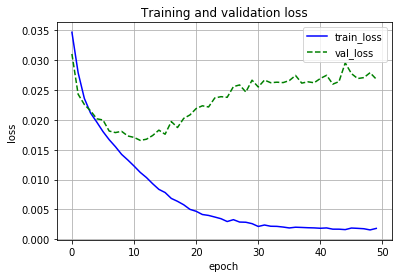

In [14]:
num_epoch=50
plt.figure()

plt.plot(range(num_epoch), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epoch), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()
plt.show()

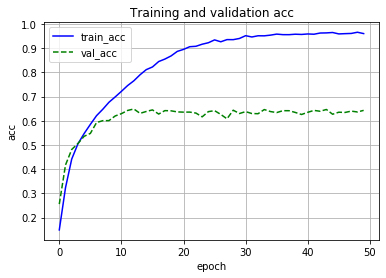

In [15]:
num_epoch=50
plt.figure()

plt.plot(range(num_epoch), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epoch), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation acc')
plt.grid()
plt.show()